<p style="text-align: center;">🍕🍔🍟🌭🍿🧂🥓🥚🥯🥨🎂🍪☕🥐🍞🌮🥪🥟<br>
</p>
<span style="font-size:28px;"><p style="text-align: center;"> Next word prediction with LSTMs. Generating food reviews. </p></span>

<p style="text-align: center;">🧈🥞🧇🍳🥖🍖🍗🍩🍵🍼🧀🥗🥩🍱🥫🌯🥡🥠
</p>

In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.optimizers import Adam
import emoji
from nltk.tokenize.treebank import TreebankWordDetokenizer
from tensorflow.keras.optimizers.schedules import ExponentialDecay
import matplotlib.pyplot as plt

2024-01-25 00:40:58.857899: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-25 00:40:58.881583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-25 00:40:58.881598: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-25 00:40:58.882200: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-25 00:40:58.886232: I tensorflow/core/platform/cpu_feature_guar

**Setting up the global variable that will be utilized throughout the process.**

In [2]:
BATCH_SIZE = 32
VALIDATION_STEPS = 50
TOTAL_TRAINING_STEPS = 100000
EVAL_EVERY_N_STEPS = 1000
MODEL_NAME = 'lstm_model'
VOCAB_SIZE = 10004
MAX_REVIEW_LEN = 1500
INITIAL_LEARNING_RATE = 1e-3
DECAY_STEPS = 30000
DECAY_RATE = 0.5
GENERATED_REVIEW_MAX_LEN = 500
LSTM_UNITS = [512,1024]
DENSE_UNITS = 1024
EMBEDDING_OUTPUT_DIM = 256

# Data preprocessing #
Reading data, making train and val split, visualizing reviews' lengths.

In [3]:
path = 'dataset/Reviews.csv'
reviews = pd.read_csv(path, usecols=['Text'])
reviews = np.squeeze(reviews, axis = 1)
reviews = np.unique(reviews)
reviews_train, reviews_val = train_test_split(reviews, test_size=0.1,random_state=2409)

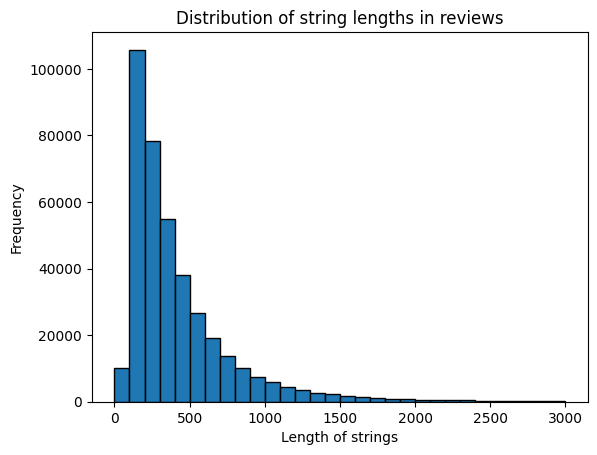

In [4]:
length_of_strings = np.vectorize(len)(reviews)
plt.hist(length_of_strings, bins=np.arange(0, 3001, 100), edgecolor='black')
plt.xlabel('Length of strings')
plt.ylabel('Frequency')
plt.title('Distribution of string lengths in reviews')
plt.show()

In [5]:
print(reviews_train[0],'\n')
print(reviews_train[2],'\n')
print(reviews_val[0],'\n')
print(reviews_val[4])

I always ask for lemon with my water. This is a great alternative to real lemons and just as delicious. 

These are some of the most FABULOUS crackers I have EVER tasted! They are a MUST when wine tasting, and in fact, are terrific any time you are serving wine and cheese. LOVE THEM!!! 

Really unfortunate.  This tastes like neither bacon nor mayo.  Not good at all.  I really wanted to like this, but not for me at all!  I am amazed at the positive comments, I just don't know what it tastes like at all.  Salty, and creamy - but not like bacon! 

I was trying to find a source for hot-smoked, shelf-stable salmon. Several brands are available through Amazon and its affiliates and I ordered a range of them to test. This is the superior product (though I gather that the King Salmon in this brand is even one step higher). It is a beautiful orange/red colour and has moist flesh with a rich and lively flavour (without excessive smoke penetration). Other brands (which had 5-star ratings) were mu

# Vocabulary #

**The following commented cells demonstrate the creation of our vocabulary dictionary. We won't execute them due to the extended processing time, as the provided notebook already includes the pre-established vocabulary.**


1. We consolidated all reviews into a single string, employing `nltk.tokenize.word_tokenize` for effective word and punctuation separation.

2. Following that, we computed the frequency of each word, splitting the resulting dictionary into values and keys. This step facilitated the creation of a vocabulary with words arranged in descending order of frequency.

3. Opting for a vocabulary size of 10,000, we arrived at this decision based on the observed ≈28:1 ratio between vocabulary words and unknown words, deeming it an acceptable balance.

4. Our vocabulary was efficiently preserved for future use using the pickle module.

In [6]:
#train_string = ' '.join(reviews_train)
#words_list = nltk.tokenize.word_tokenize(train_string)

In [7]:
#words_and_frequency = nltk.FreqDist(words_list)
#counts = list(words_and_frequency.values())
#words = list(words_and_frequency.keys())
# counts = np.array(counts)
# words =np.array(words)

In [8]:
# count_sort_ind = np.argsort(-counts)

In [9]:
# words = words[count_sort_ind]
# counts = counts[count_sort_ind]

In [10]:
# counts[:10000].sum()/counts[10000:].sum()

In [11]:
# vocabulary = dict(zip(words, counts))
# with open('vocabulary.pkl', 'wb') as fp:
#     pickle.dump(vocabulary, fp)

In [12]:
# Read dictionary pkl file
with open('vocabulary.pkl', 'rb') as fp:
    vocabulary = pickle.load(fp)

**Adding special tokens (padding, start of sentence, end of sentence, unknown) to our vocabulary.**

**We are creating dictionaries to map strings to indices and vice versa.**

In [13]:
word2idx = {'<PAD>':0, '<SOS>':1, '<EOS>':2, '<UNK>':3}
word2idx_update = dict(zip(vocabulary.keys(), range(4,VOCAB_SIZE)))

In [14]:
word2idx.update(word2idx_update)
for i,j in zip(range(5),word2idx.items()):
    print(i,j)

0 ('<PAD>', 0)
1 ('<SOS>', 1)
2 ('<EOS>', 2)
3 ('<UNK>', 3)
4 ('.', 4)


In [15]:
idx2word = dict(zip( word2idx.values(),word2idx.keys()))
for i,j in zip(range(5),idx2word.items()):
    print(i,j)

0 (0, '<PAD>')
1 (1, '<SOS>')
2 (2, '<EOS>')
3 (3, '<UNK>')
4 (4, '.')


# Creating tensorflow datasets

In [16]:
def tokenize(review):
    """
    Split reviews into tokens.
    """
    review = review.decode('utf-8')
    words_list = nltk.tokenize.word_tokenize(review)
    index_list = [word2idx['<SOS>']]
    for word in words_list:
        index = word2idx.get(word,word2idx['<UNK>'])
        index_list.append(index)
    index_list.append(word2idx['<EOS>'])
    return np.array(index_list).astype(np.int32)

def map_fn(review):
    """
    Apply tokenize to elements and setting maximum review length to 1500.
    """
    x = tf.numpy_function(tokenize, inp = [review], Tout = tf.int32)
    x = tf.ensure_shape(x, [None])
    return x[:MAX_REVIEW_LEN]

def batch_map_fn(batch):
    """
    Creating inputs and targets by removing last and first element respectively.
    """
    x=tf.shape(batch) 
    inputs = batch[:,0:x[1]-1]
    outputs = batch[:,1:x[1]]
    return inputs, outputs

In [17]:
def make_dataset(reviews, shuffle):
    dataset = tf.data.Dataset.from_tensor_slices(reviews)

    if shuffle:
        dataset = dataset.shuffle(buffer_size = dataset.cardinality(), reshuffle_each_iteration=True)
    dataset = dataset.map(map_fn, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.padded_batch(batch_size = BATCH_SIZE, padding_values=word2idx['<PAD>'] , drop_remainder = True)
    dataset = dataset.map(batch_map_fn, num_parallel_calls = tf.data.AUTOTUNE)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [18]:
dataset_train = make_dataset(reviews_train, shuffle=True) # (inputs, targets)
dataset_val = make_dataset(reviews_val, shuffle=True) # (inputs, targets)

2024-01-25 00:41:02.967230: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 00:41:02.989034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-01-25 00:41:02.989151: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

# Building model

In [19]:
class LSTMBlock(tf.keras.layers.Layer):
    """
    Class that creates LSTM layers based on list of units
    """
    def __init__(self, name='lstm_block'):
        super(LSTMBlock, self).__init__(name=name)
        self.lstm_list=[]        
        for units in LSTM_UNITS:            
            self.lstm_list.append(LSTM(units, return_sequences=True))
                
    def call(self,x, training):
        for lstm in self.lstm_list:
            x = lstm(x, training=training)
        return x        

class LSTMModel(Model):
    """
    Class that takes an input and runs it through model layers
    """
    def __init__(self, name='food_review_generation'):
        super(LSTMModel, self).__init__(name=name)
        self.embedding = Embedding(input_dim=VOCAB_SIZE, output_dim=EMBEDDING_OUTPUT_DIM)
        self.lstm_block = LSTMBlock()
        self.dense = Dense (DENSE_UNITS, activation='relu')
        self.output_layer = Dense(VOCAB_SIZE)
        
    def call(self, inputs, training):
        x = self.embedding(inputs)
        x = self.lstm_block(x, training)
        x = self.dense(x)
        x = self.output_layer(x)
        return x
    
    def model(self):
        x = Input((None,))
        return Model(inputs=x, outputs=self.call(x, True))

In [20]:
model = LSTMModel()
model.model().summary()

2024-01-25 00:41:03.523290: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         2561024   
                                                                 
 lstm_block (LSTMBlock)      (None, None, 1024)        7870464   
                                                                 
 dense (Dense)               (None, None, 1024)        1049600   
                                                                 
 dense_1 (Dense)             (None, None, 10004)       10254100  
                                                                 
Total params: 21735188 (82.91 MB)
Trainable params: 21735188 (82.91 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Custom metrics
We created custom loss and accuracy to provide better model evaluation because we used masking to remove padding out of metrics calculations.

In [21]:
class MaskedSparseCategoricalCrossentropy(tf.keras.losses.Loss):
    """
    Sparse categorical crossentropy but padding isn't counted in equation.
    """
    def __init__(self, name='masked_sparse_categorical_crossentropy', **kwargs):
        super(MaskedSparseCategoricalCrossentropy, self).__init__(name=name, **kwargs)
        self.scce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)

    def call(self, y_true, y_pred):     
        
        loss = self.scce(y_true, y_pred) # y_true(B,T) y_pred(B,T,C)
        mask = tf.where(y_true == word2idx['<PAD>'], 0., 1.) # (B,T)
        loss = tf.reduce_sum(loss * mask)/ tf.reduce_sum(mask) # ()
        return loss
    
def get_tokens(logits):
    """
    Transforms logits to tokens with argmax and random sampling with gumbel noise trick.
    """
    y_pred_argmax = tf.argmax(logits, axis=-1, output_type=tf.int32)
    
    rand_uniform = tf.random.uniform(tf.shape(logits), minval=1e-5, maxval=1. - 1e-5)
    gumbel_noise = -tf.math.log(-tf.math.log(rand_uniform))
    y_pred_sampling = tf.argmax(logits + gumbel_noise, axis=-1, output_type=tf.int32)
    return y_pred_argmax, y_pred_sampling

    
def masked_sparse_categorical_accuracy(y_true, y_pred): 
    mask = tf.where(y_true == word2idx['<PAD>'], 0., 1.) # (B,T)
    accuracy = tf.reduce_sum(tf.cast(tf.equal(y_true, y_pred), tf.float32)*mask)/tf.reduce_sum(mask)
    return accuracy


# Callbacks
Create model saving and loading + TB callbacks

In [22]:
def create_checkpoint_manager(checkpoint_path, model, optimizer, max_allowed_checkpoints=5):
    checkpoint_starter = tf.Variable(0, trainable=False, dtype=tf.int32)
    checkpoint = tf.train.Checkpoint(optimizer=optimizer, model=model, checkpoint_starter=checkpoint_starter)
    manager = tf.train.CheckpointManager(checkpoint=checkpoint, directory=checkpoint_path, max_to_keep=max_allowed_checkpoints)    
    return manager

def save_checkpoint(step, checkpoint_manager):
    checkpoint_manager.checkpoint.checkpoint_starter.assign(step)
    checkpoint_manager.save(step)
    
def load_checkpoint_if_exists(manager):
    checkpoint_path = manager.directory
    checkpoint = manager.checkpoint
    try:
        checkpoint_state = tf.train.get_checkpoint_state(checkpoint_path)
        if checkpoint_state and checkpoint_state.model_checkpoint_path:
            print('Loading checkpoint from: {}'.format(checkpoint_state.model_checkpoint_path))
            checkpoint.restore(checkpoint_state.model_checkpoint_path)
        
        else:
            print('No model to load at {}'.format(checkpoint_path))
    
    except tf.errors.OutOfRangeError as e:
        raise tf.errors.OutOfRangeError('Cannot restore checkpoint: {}'.format(e))
    
def tensorboard_log(summary_writer, loss_value, argmax_accuracy, sampling_accuracy, step):
    with summary_writer.as_default():
        tf.summary.scalar('loss', loss_value, step=step)
        tf.summary.scalar('argmax_accuracy', argmax_accuracy, step=step)
        tf.summary.scalar('sampling_accuracy', sampling_accuracy, step=step)
    summary_writer.flush()


**Utility functions to detokenize targets and model outputs for visualization purposes.**

In [23]:
detokenizer = TreebankWordDetokenizer()

def detokenize_x(x):
    """
    Turns tokens into words for our input samples.
    """
    token_list_x = []
    for token in x:
        if token != word2idx['<PAD>']:
            word = idx2word[token]
            token_list_x.append(word)
    limit = len(token_list_x)
    print('Target: ',detokenizer.detokenize(token_list_x))
    print('')
    return limit

def detokenize_y(y, limit, argmax_or_sampling):
    """
    Turns tokens into words of length of input sample for output samples.
    """
    token_list_y = []
    for token in y[:limit]:
        word = idx2word[token]
        token_list_y.append(word)
    print(argmax_or_sampling,detokenizer.detokenize(token_list_y))
    print('')    

# Creating train and val step graphs

In [24]:
@tf.function(input_signature=[tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32), tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32)])
def train_step( x, y):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)
    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))
    return loss_value, logits

@tf.function(input_signature=[tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32), tf.TensorSpec(shape=[BATCH_SIZE, None], dtype=tf.int32)])
def val_step(x,y):
    logits = model(x, training=False)
    loss_value = loss_fn(y, logits)
    return loss_value, logits

def validate(dataset_val, step, data_name):
    avg_val_loss = 0.
    avg_val_argmax_acc = 0.
    avg_val_sampling_acc = 0.

    for i,(x_batch_val, y_batch_val) in zip(range(VALIDATION_STEPS),dataset_val):
        loss_value, logits = val_step(x_batch_val, y_batch_val) 
        avg_val_loss += loss_value 

        y_pred_argmax, y_pred_sampling = get_tokens(logits)
        val_argmax_acc = masked_sparse_categorical_accuracy(y_batch_val, y_pred_argmax)
        val_sampling_acc = masked_sparse_categorical_accuracy(y_batch_val, y_pred_sampling)
        avg_val_argmax_acc += val_argmax_acc
        avg_val_sampling_acc += val_sampling_acc

    avg_val_loss /= (i + 1)
    avg_val_argmax_acc /= (i + 1)
    avg_val_sampling_acc /= (i + 1)
    print(f"{data_name} loss at step {step}: {avg_val_loss:.4f}")
    print(f"{data_name} argmax acc at step {step}: {avg_val_argmax_acc:.2f}")
    print(f"{data_name} sampling acc at step {step}: {avg_val_sampling_acc:.2f}")

    limit = detokenize_x(y_batch_val[0].numpy())
    detokenize_y(y_pred_argmax[0].numpy(), limit, 'Argmax: ')
    detokenize_y(y_pred_sampling[0].numpy(), limit, 'Sampling: ') 
    
    return avg_val_loss, avg_val_argmax_acc, avg_val_sampling_acc

**Instantiating loss function, optimizer and TB summary writers.**

In [25]:
loss_fn = MaskedSparseCategoricalCrossentropy()
lr_schedule = ExponentialDecay(initial_learning_rate=INITIAL_LEARNING_RATE,
                               decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=False, name=None)
optimizer = Adam(lr_schedule)
manager = create_checkpoint_manager(f'checkpoints/{MODEL_NAME}', model, optimizer)
load_checkpoint_if_exists(manager)

train_summary_writer = tf.summary.create_file_writer(f'tb_logs/{MODEL_NAME}/train')
val_summary_writer = tf.summary.create_file_writer(f'tb_logs/{MODEL_NAME}/val')

No model to load at checkpoints/lstm_model


**Making training loop.**

In [26]:
def train(dataset_train, dataset_val, train_summary_writer, val_summary_writer, manager):
    initial_step = manager.checkpoint.checkpoint_starter.read_value().numpy()
    best_val_loss = 2**16
    pbar = tf.keras.utils.Progbar(EVAL_EVERY_N_STEPS, stateful_metrics=['loss'])
    
    print('Training started! \U0001F973 \n_____________________________________________________')

    for step, (x_batch_train, y_batch_train) in zip(range(initial_step+1,TOTAL_TRAINING_STEPS+1),dataset_train):
        loss_value, logits = train_step(x_batch_train, y_batch_train) 

        pbar.update(step % EVAL_EVERY_N_STEPS, [('loss', loss_value)])

        if step % EVAL_EVERY_N_STEPS == 0:
            print(f"\nSeen so far: {(step + 1) * BATCH_SIZE} samples")

            avg_train_loss, avg_train_argmax_acc, avg_train_sampling_acc = validate(dataset_train, step, data_name='Training')    
            avg_val_loss, avg_val_argmax_acc, avg_val_sampling_acc = validate(dataset_val, step, data_name='Validation')

            tensorboard_log(train_summary_writer, avg_train_loss, avg_train_argmax_acc, avg_train_sampling_acc, step)
            tensorboard_log(val_summary_writer, avg_val_loss, avg_val_argmax_acc, avg_val_sampling_acc, step)
            print(f'SAVED LOGS TO TENSORBOARD FOR STEP {step}..')

            if avg_val_loss <= best_val_loss:      
                best_val_loss = avg_val_loss
                save_checkpoint(step, manager)
                print(f'SAVED CHECKPOINT FOR STEP {step}..')

            print("_____________________________________________________")   

        if step == TOTAL_TRAINING_STEPS:
            print('Training complete! \U0001F929')


# Train

In [27]:
train(dataset_train=dataset_train, dataset_val=dataset_val, train_summary_writer=train_summary_writer,
     val_summary_writer=val_summary_writer, manager=manager)

Training started! 🥳 
_____________________________________________________


2024-01-25 00:41:07.452237: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-01-25 00:41:07.845229: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f2f8c1b4d50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-25 00:41:07.845248: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-01-25 00:41:07.849091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1706161267.914700   11424 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


   0/1000 [..............................] - ETA: 0s - loss: 4.3429
Seen so far: 32032 samples
Training loss at step 1000: 4.5487
Training argmax acc at step 1000: 0.22
Training sampling acc at step 1000: 0.11
Target:  There are WAY too many flavors going on in this breakfast cookie...at least for my tastebuds . <UNK> was in charge of adding spices really went too far--to the point that it is actually <UNK>. Obviously, I won't be ordering this one again . <EOS>

Argmax:  I are a a sweet <UNK>. to the the product . . I the the the favorite . I, a the . the a and <UNK> to . . I be <UNK> of is is a a . <EOS>, it 'mn't be able again product again . <EOS>

Sampling:  This is under a <UNK> jars from to supermarkets hot day ., <UNK> the . the entire because I when not a even the protein (bread on . with and work. only and the wasn't several . My extra it don't recommend disappointed in one for . <EOS>

Validation loss at step 1000: 4.5767
Validation argmax acc at step 1000: 0.22
Validation sa

# Generating new review

In [28]:
lr_schedule = ExponentialDecay(initial_learning_rate=INITIAL_LEARNING_RATE,
                               decay_steps=DECAY_STEPS, decay_rate=DECAY_RATE, staircase=False, name=None)
optimizer = Adam(lr_schedule)

manager = create_checkpoint_manager(f'checkpoints/{MODEL_NAME}', model, optimizer)
load_checkpoint_if_exists(manager)

Loading checkpoint from: checkpoints/lstm_model/ckpt-100000


In [29]:
def tokenize_test_string(test_string):
    words_list = nltk.tokenize.word_tokenize(test_string)
    index_list = [word2idx['<SOS>']]
    for word in words_list:
        index = word2idx.get(word,word2idx['<UNK>'])
        index_list.append(index)
    return np.array(index_list).astype(np.int32)

@tf.function(input_signature=[tf.TensorSpec(shape=[1, None], dtype=tf.int32), tf.TensorSpec(shape=(), dtype=tf.float32)])
def get_test_tokens(x, temperature): # (B,T)
    logits = model(x, training=False)[:,-1:,:] # (B,1,C) 
    rand_uniform = tf.random.uniform(tf.shape(logits), minval=1e-5, maxval=1. - 1e-5) # (B,1,C)
    gumbel_noise = -tf.math.log(-tf.math.log(rand_uniform)) # (B,1,C)
    y_pred_sampling = tf.argmax(logits / temperature + gumbel_noise, axis=-1, output_type=tf.int32) # (B,1)
    x = tf.concat([x, y_pred_sampling], axis=1) # (B,T+1)
    return x

def detokenize_generated_review(x):
    token_list_x = []
    for token in x:
        word = idx2word[token]
        token_list_x.append(word)
    return detokenizer.detokenize(token_list_x)

def generate_review(x='', temperature=1.):
    temperature=tf.convert_to_tensor(temperature)
    x = tf.convert_to_tensor(tokenize_test_string(x))[tf.newaxis,:] # (1, T)
    for step in range(GENERATED_REVIEW_MAX_LEN):
        x = get_test_tokens(x, temperature) # (1, T)
        if x[0, -1]==word2idx['<EOS>']:
            break
    x = x[0,:].numpy() # (T,)
    return detokenize_generated_review(x)

In [30]:
generate_review()

"<SOS> Based on the item description, I decided this seasoning would be excellent . It arrived with some really yummy spices, and they were delicious . Its a mild garlic flavour . If you like salt as the coriander is too salty for you, then this is a perfectly good one . I have also used a <UNK> <UNK>. I like it and not only do I use the ground beef in place of salt but I can be on a gluten free pantry . Thank you . I can finally have added turmeric, garlic and <UNK> to my sandwich (but can't just hydrate properly). It gives a nice <UNK> in the whole dish . Yum! You won't regret it . <EOS>"

In [39]:
generate_review('I am disappointed', temperature=0.7)    # less temperature = less randomness

'<SOS> I am disappointed to find out that this product is made in Singapore and not the full size . I did not read the label before purchasing . The brand that is on the label is misleading . <EOS>'

In [38]:
generate_review(temperature=0.7)

"<SOS> My little guy is very picky when it comes to oatmeal so I thought I would give this a try . It did not live up to my expectations . This cereal is not very sweet and has a lot of sugar . While it isn't the <UNK> of cereal I would have given it 5 stars . I would recommend trying it out and see if you like it, it's very good . <EOS>"

In [37]:
generate_review('Pizza was delicious and', temperature=0.7)

'<SOS> Pizza was delicious and the price was right . It was delivered promptly and was packaged nicely . <EOS>'

In [36]:
generate_review('nom nom ', temperature=0.7)

"<SOS> nom nom nom nom nom, YUMMY! I love this stuff, I haven't been able to find it in <UNK>, so I'm glad I found it on Amazon . It's so much better than the <UNK> <UNK> (?)--and it's BETTER!!! <EOS>"